<a href="https://colab.research.google.com/github/AlphaSierraDelta2849/Fraud-Detection/blob/main/Fraud_detection_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contexte:
Il est très important pour les institutions bancaires de pouvoir se doter de systèmes capables de détecter les tentatives de fraudes d'individus malveillants. Pour cela, l'apprentissage automatique fournit une solution à travers notamment Spark ML qui est un outil puissant pour faire l'analyse et la prédiction. On se basera sur les données de fournies pour entrainer notre modèle et par la suite nous le déploierons avec Spark Streaming. Ici, le problème identifié est un problème de classification car il s'agit de déterminer si oui ou non on a affaire à une fraude en se basant sur les paramètres fournis.

#Configuration environnement

##Installation des outils nécessaires pour l'environnement d'exécution

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark==3.4.0
!pip install py4j
!pip install imbalanced-learn

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 3s (88.8 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open

##Importation des bibliothèques nécessaires

In [2]:
import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StandardScaler,VectorAssembler
# from pyspark.ml.linalg import Vectors, VectorUDT
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from pyspark.ml.classification import RandomForestClassifier,GBTClassifier, LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

##Création de la session spark

In [3]:
spark= SparkSession \
       .builder \
       .appName("Fraud Detection") \
       .getOrCreate()

spark

##Importation des données:
Vu qu'on s'est servi de Colab pour exécuter ce notebook. On doit importer le dataset depuis Google Drive.

In [4]:
drive.mount('/content/drive')
df = spark.read.csv('/content/drive/My Drive/csv_files_colab/fraud_detection/creditcard.csv',header=True, inferSchema=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Analyse Exploratoire

##Affichage des types de données

In [5]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

On remarque que toutes les variables de type double (décimal) hormis la variable cible qui est la classe de type entier. Ce dernier prend uniquement 2 valeurs 0 pour indiquer 'non fraude' et 1 en cas de fraude. Nous sommes donc en face d'un problème de classification

##Visualisation des données

In [6]:
df.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

Nous remarquons que les données sont déjà encodées grace à la méthode ACP(Analyse Composante Principale) qui est une méthode de réduction de dimensions. Ceci est du au fait que dans les transactions bancaires il faut encoder les données à caractère personnelle par mesure de sécurité. De ce fait, nous n'avons que le montant et le temps qui sont clairement définis. Cela limite malheureusement l'analyse exploratoire qu'on peut en faire.

##Affichage résumé

In [7]:
# Résumé des différentes variables
df.summary().show()

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|

Nous avons en tout 284807 lignes

##Valeurs Manquantes

In [8]:
# Affichage des données manquantes
missing_values = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
total_values = df.count()
missing_values_pct = missing_values.select([F.round((F.col(c) / total_values * 100),2).alias(c) for c in df.columns])
missing_values_pct.show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
| 0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|   0.0|  0.0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



On remarque que le dataset ne comporte aucune donnée manquante.

##Etude de la cardinalité des variables Time, Amount et Class

In [9]:
newDf=df.select(['Time','Amount','Class'])

for col in newDf.columns:
  display(col)
  display(newDf.select(col).distinct().count())

'Time'

124592

'Amount'

32767

'Class'

2

Cela nous confirme que les variables temps et montant sont qualitatifs continus tandis que la classe est bien catégorielle et précisément binaire. Toutes les autres variables sont déjà encodées avec la méthode ACP.

##Etude de la distribution de la variable cible.

In [10]:
rows_number=df.count()
display(rows_number)
dfWithClassCounts=df.groupBy(df.Class).agg(F.count('*').alias("class_count"))
dfWithAVGClass=dfWithClassCounts.withColumn('class_mean',F.round(dfWithClassCounts.class_count/rows_number,4))
dfWithAVGClass.show()

284807

+-----+-----------+----------+
|Class|class_count|class_mean|
+-----+-----------+----------+
|    1|        492|    0.0017|
|    0|     284315|    0.9983|
+-----+-----------+----------+



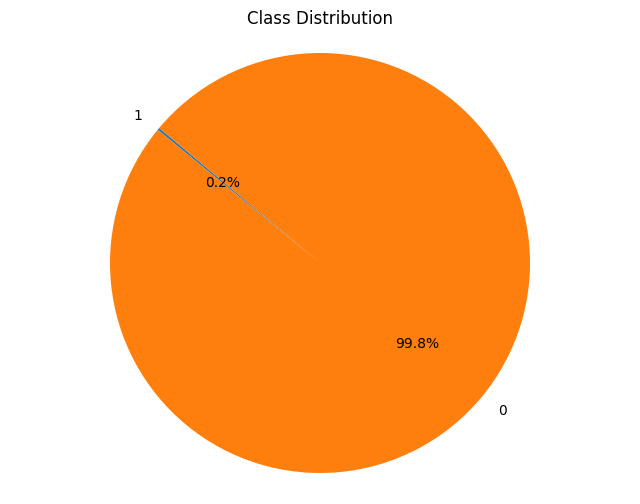

In [11]:

plt.figure(figsize=(8,6))
plt.pie(dfWithClassCounts.toPandas().class_count,labels=dfWithClassCounts.toPandas().Class,autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

La variable Class à prédire est très déséquilibrée. Nous avons seulement 0.17%. C'est un double challenge pour la suite car nous devons non seulement mettre en place un modèle capable de prédire les cas de fraude sans pour autant se tromper sur les transactions normales sinon cela entachera la réputation de l'institution financière.

##Etude de la corrélation

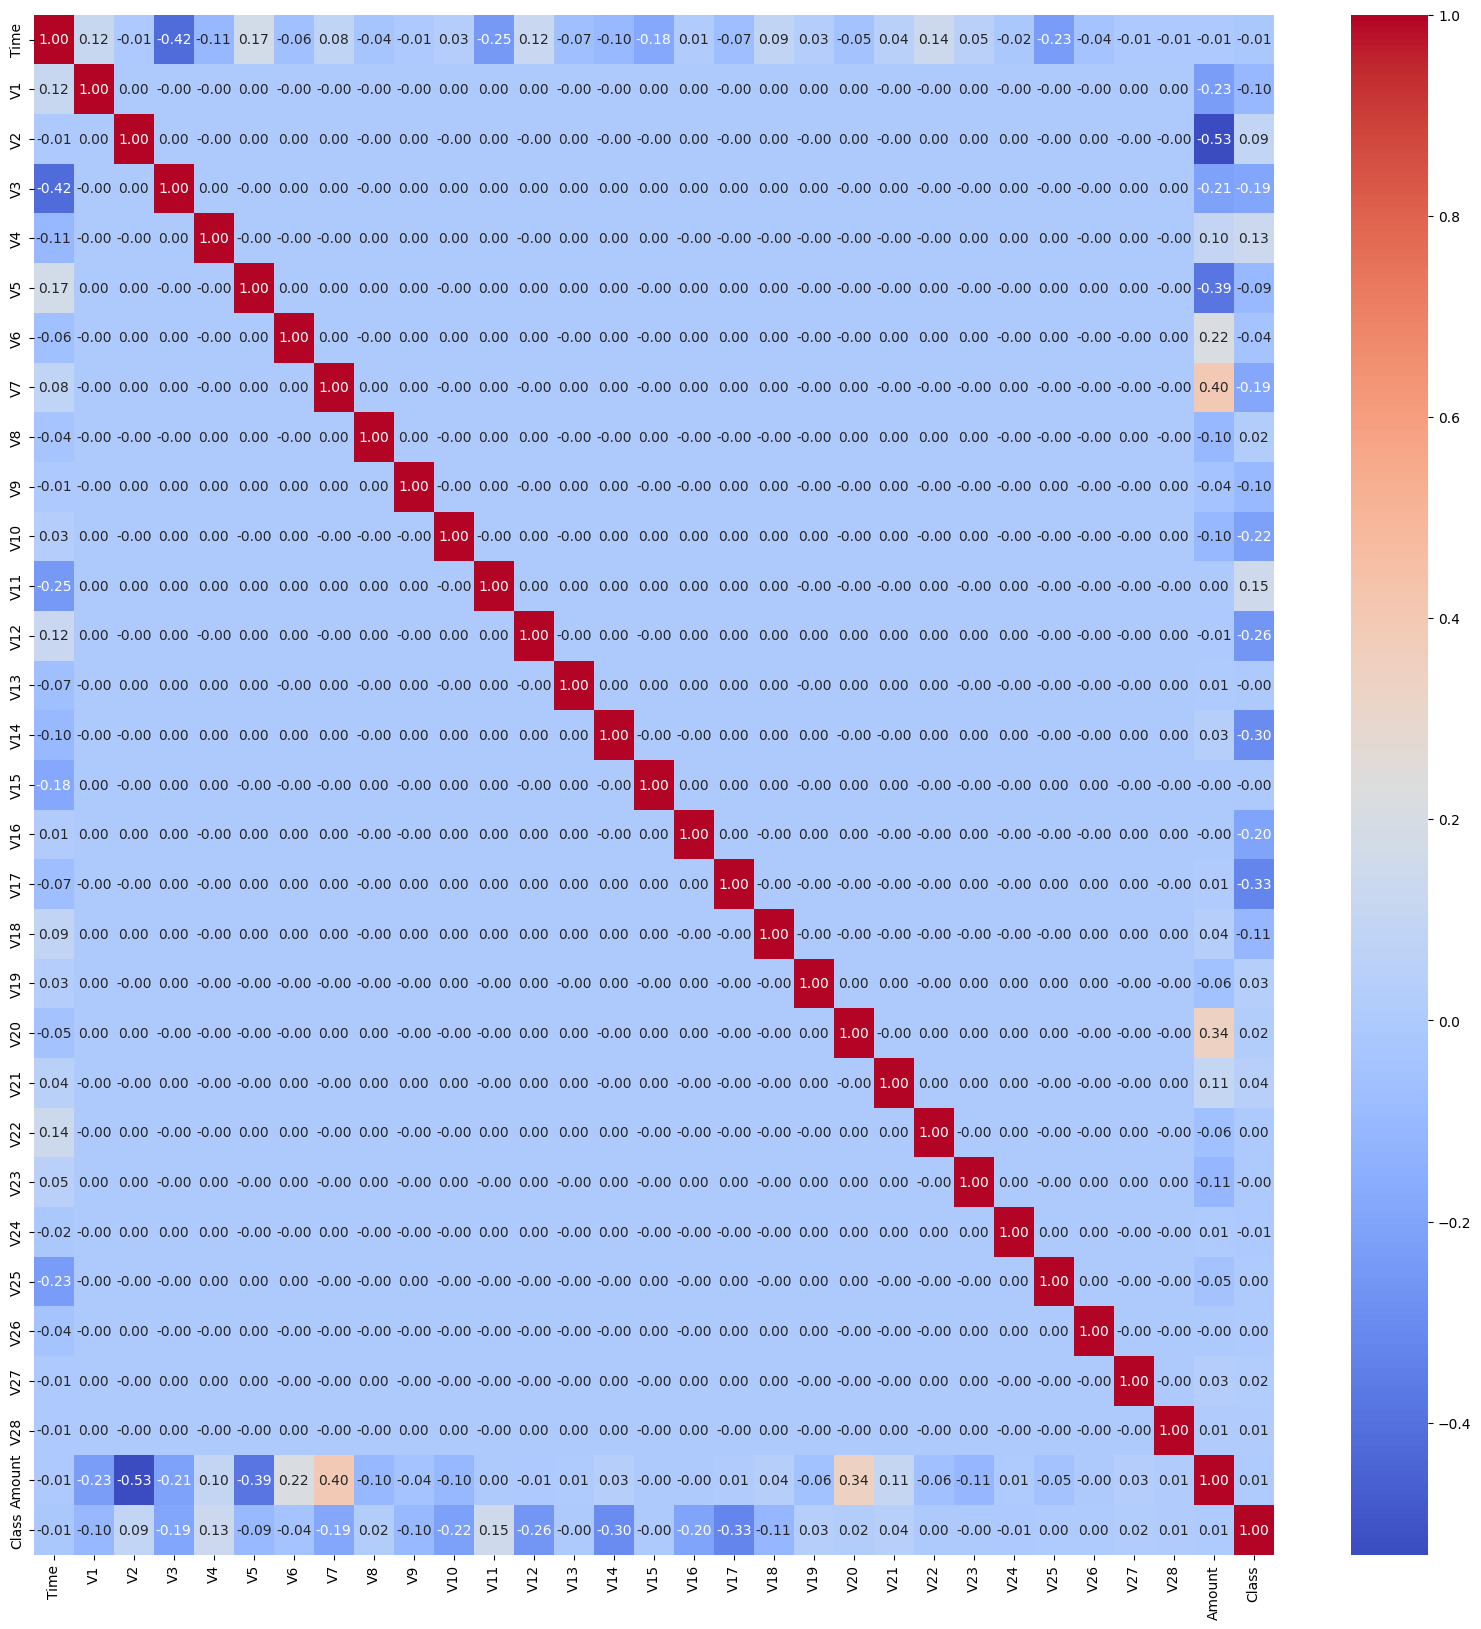

In [12]:
#Matrice de corrélation
corr_df = df.toPandas()

correlation_matrix = corr_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

La matrice montre qu'il n' y a pas une forte corrélation entre 2 variables. En outre, il existe des variables qui n'ont aucune corrélation avec la variable cible. On pourra s'en passer dans la suite pour rendre le modèle moins complexe.

#Traitement des données

##Sélection des variables

Basé sur la matrice de corrélation(voir matrice de corrélation) on a supprimé les variables qui n'ont aucune corrélation avec la cible

In [13]:
# Exclusion des variables moins importantes
columns_to_exclude = ["V13", "V15", "V22","V23","V25"]
selected_columns = [col for col in df.columns if col not in columns_to_exclude]
df_selected = df.select(selected_columns)
# 13,15,22,23,25,26,28

##Standardisation du montant "Amount":
 Vu que les autres colonnes ont été standardisées avant l'application de l'ACP, nous allons aussi standardiser le montant

In [14]:
mean_age, sttdev_age = df_selected.select(F.mean("Amount"), F.stddev("Amount")).first()
scaledData=df_selected.withColumn("Amount_scaled", (df_selected.Amount - mean_age) / sttdev_age)
scaledData=scaledData.drop("Amount")
scaledData.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+------------------+------------------+--------------------+-------------------+-----+-------------------+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V14|               V16|               V17|                V18|               V19|                V20|                 V21|               V24|               V26|                 V27|                V28|Class|      Amount_scaled|
+----+------------------+---------------

##Echantillonage:
L'analyse de la distribution de la variable cible nous a révélé un dataset très déséquilibré sur le plan fraude/non fraude. Ce qui risque de tromper le modèle. C'est pour cela que nous avons décidé de rééchantillonner. Comme technique nous avons opté pour le suréchantillonnage avec la méthode SMOTE car le souséchantillonage entrainera un underfitting(sous-apprentisage) vu le nombre réduit de nos données frauduleuses(495).
Cependant pour éviter un surapprentissage(overfitting), nous devons auparavant séparer les données de test et d'entrainement. Le rééchantillonnage s'effectuera uniquement sur les données d'entrainement. Le modèle sera par contre évalué par rapport aux données de test.

In [15]:
# Séparer les autres variables de la cible
newDf=scaledData.toPandas()
features = newDf.drop('Class',axis=1)
target = newDf['Class']

# Séparer les donnéss en test et entrainement
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Echantillonage avec la méthode SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
train_data = spark.createDataFrame(pd.concat([X_train_resampled,y_train_resampled],axis=1))
test_data = spark.createDataFrame(pd.concat([X_test,y_test],axis=1))
# Afficher la disribution
print("Class distribution after oversampling:")
print(y_train_resampled.value_counts())


Class distribution after oversampling:
Class
0    227451
1    227451
Name: count, dtype: int64


Après l application de la méthode SMOTE, on obtient un dataset équitablement réparti. Ce qui est idéal pour un problème de classification.

#Entrainement et Evaluation

##Préparation des données à l'aide de pipelines

In [16]:
# Exclure la variable cible
feature_columns = scaledData.columns[:-1]
# Convertir les features en un vecteur pour l'entrainement
assembler_lr = VectorAssembler(inputCols=feature_columns, outputCol="features_lr")
assembler_rf = VectorAssembler(inputCols=feature_columns, outputCol="features_rf")
assembler_gbt = VectorAssembler(inputCols=feature_columns, outputCol="features_gbt")
# Définition des différents modèles de classification

# Random Forest
rf = RandomForestClassifier(labelCol="Class", featuresCol="features_rf", numTrees=100, maxDepth=5)

# Gradient Boosting Machines (GBM)
gbt = GBTClassifier(labelCol="Class", featuresCol="features_gbt", maxDepth=5, maxIter=20, seed=42)

# Logistic Regression
lr = LogisticRegression(labelCol="Class", featuresCol="features_lr")

# Créer les pipelines pour différents algorithmes
pipeline_lr = Pipeline(stages=[assembler_lr, lr])
pipeline_rf = Pipeline(stages=[assembler_rf, rf])
pipeline_gbt = Pipeline(stages=[assembler_gbt, gbt])

##Fonction pour afficher les métriques

In [17]:
def show_metrics(precision,recall,f1_score,auc,confusionMatrix):
    # Step 8: Output the precision
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-1 score: ", f1_score)
    print("AUC: ", auc)
    print("Matrice de confusion: ")
    print(confusionMatrix)

##Fonction d'entrainement et d'exécution

In [18]:
models_temoin=[]
# Entraîner et évaluer les modèles pour chaque pipeline
def train_and_evaluate(pipeline,model_type):
    model = pipeline.fit(train_data)
    models_temoin.append(model)
    predictions = model.transform(test_data)
    predictions=predictions.withColumn("class",predictions["class"].cast(T.DoubleType()))
    # Extracting (prediction, label) pairs from the DataFrame
    prediction_and_label = predictions.select("prediction", "class").rdd
    # Affichage de quelques exemples de prédictions
    predictions.select("prediction","probability","class").filter(predictions.prediction==1).show(10)
    print("Métriques d'évaluation :")

    # calculer les différents métriques
    evaluator = BinaryClassificationEvaluator(labelCol="class")
    auc = evaluator.evaluate(predictions)
    metrics = MulticlassMetrics(prediction_and_label)
    classValue=float(1)
    precision = metrics.precision(classValue)
    recall = metrics.recall(classValue)
    f1_score = metrics.fMeasure(classValue)
    confusionMatrix=metrics.confusionMatrix().toArray()
    show_metrics(precision,recall,f1_score,auc,confusionMatrix)

    # Sauvegarder le modèle
    path="/content/drive/My Drive/csv_files_colab/fraud_detection/models/"+str(model_type)
    model.write().overwrite().save(path)
    print(f"modèle {model_type} sauvegardé")

##Exécution des algorithmes.

In [ ]:
# Entraîner et évaluer le modèle Logistic Regression
print("Modèle de régression logistique")
train_and_evaluate(pipeline_lr,"lr")
print("*******************************\n")

# Entraîner et évaluer le modèle Random Forest
print("Modèle de Foret aléatoire")
auc_rf = train_and_evaluate(pipeline_rf,"rf")
print("*******************************\n")

# Entraîner et évaluer le modèle Gradient Boosted Tree
print("Modèle de gradient Boosted Tree")
auc_gbt = train_and_evaluate(pipeline_gbt,"gbt")

Modèle de régression logistique
+----------+--------------------+-----+
|prediction|         probability|class|
+----------+--------------------+-----+
|       1.0|[4.52078591552543...|  1.0|
|       1.0|[1.59689004542431...|  1.0|
|       1.0|[1.79319861194858...|  1.0|
|       1.0|[1.51542013091705...|  1.0|
|       1.0|[1.18768960483243...|  1.0|
|       1.0|[5.77779503033017...|  1.0|
|       1.0|[3.68836383174933...|  1.0|
|       1.0|[9.53140027171825...|  1.0|
|       1.0|[2.83982019735643...|  1.0|
|       1.0|[1.57804802370119...|  1.0|
+----------+--------------------+-----+
only showing top 10 rows

Métriques d'évaluation :


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision:  1.0
Recall:  1.0
F-1 score:  1.0
AUC:  0.9999448200073502
Matrice de confusion: 
[[56864.     0.]
 [    0.    98.]]
modèle lr sauvegardé
*******************************

Modèle de Foret aléatoire
+----------+--------------------+-----+
|prediction|         probability|class|
+----------+--------------------+-----+
|       1.0|[0.00111283620143...|  1.0|
|       1.0|[0.01257308478267...|  1.0|
|       1.0|[0.00179235145497...|  1.0|
|       1.0|[0.36828515666546...|  1.0|
|       1.0|[0.23929066144070...|  1.0|
|       1.0|[0.00109401907104...|  1.0|
|       1.0|[0.00111283620143...|  1.0|
|       1.0|[0.00962758782276...|  1.0|
|       1.0|[0.01202395398743...|  1.0|
|       1.0|[0.01259260178000...|  1.0|
+----------+--------------------+-----+
only showing top 10 rows

Métriques d'évaluation :
Precision:  1.0
Recall:  1.0
F-1 score:  1.0
AUC:  0.9999919248791244
Matrice de confusion: 
[[56864.     0.]
 [    0.    98.]]
modèle rf sauvegardé
*******************************


##Vérification:
L'évaluation montre qu'on a un modèle qui distingue parfaitement les fraudes des cas de non-fraude. Cela nous permet de relever un double challenge. Non seulement le modéle pourra détecter les transactions malveillantes mais aussi les transactions non frauduleuses se passeront sans désagréments pour éviter de perdre la cote au niveau de la clientèle.
Cependant, on peut aussi penser que le modèle a surappri. Pour cela, nous pouvons comparer l'aire sous la courbe ROC(AUC) des données tests et d'entrainement. En effet, l'AUC est un métrique informatif pour les problèmes de classification binaire.

In [ ]:
# Evaluer les performances sur l'ensemble d'entraînement
train_predictions = models_temoin[0].transform(train_data)
train_evaluator = BinaryClassificationEvaluator(labelCol='Class')
train_auc = train_evaluator.evaluate(train_predictions)
# Evaluer les performances sur l'ensemble de test
test_predictions = models_temoin[0].transform(test_data)
test_evaluator = BinaryClassificationEvaluator(labelCol='Class')
test_auc = test_evaluator.evaluate(test_predictions)

print("AUC on training data:", train_auc)
print("AUC on test data:", test_auc)

On obtient des resultats quasi-identiques. Donc on peut conclure que notre modèle n'a pas sur appris.